In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

package_path = os.path.abspath('../../../dolphindes')
if package_path not in sys.path:
    sys.path.append(package_path)

from dolphindes import photonics

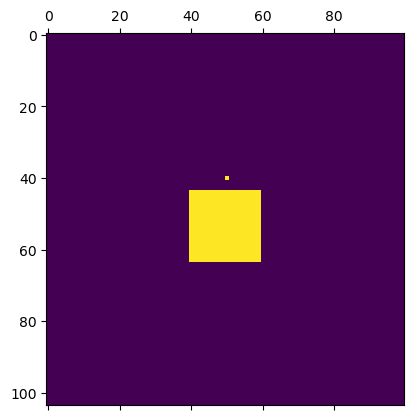

In [2]:
# First, let's define the relevant parameters for the simulation. 

wavelength = 1.0 # Dolphindes uses dimensionless units. 
omega = 2 * np.pi / wavelength
chi = 4+1e-4j # Design material 
px_per_length = 40 # pixels per length unit. If wavelength = 1.0, then this is pixels per wavelength.
dl = 1/px_per_length 
Npmlsep = int(0.5 / dl) # gap between design region and PML. Not required to be defined, it is just convenient.
Npmlx, Npmly = int(0.5 / dl), int(0.5 / dl) # PML size.
Mx, My = int(0.5 / dl), int(0.5 / dl) # design mask size 
Dx = int(0.1 / dl) # distance from the design region to the source region.
Nx, Ny = int(Npmlx*2 + Npmlsep*2 + Dx + Mx), int(Npmly*2 + Npmlsep*2 + My) # grid size. This includes the pml layer!

cx, cy = Npmlx + Npmlsep, Ny//2

ji = np.zeros((Nx, Ny), dtype=complex) # current density
ji[cx, cy] = 1.0/dl/dl # a delta function source in 2D is approximated by amplitude 1/dl/dl so that integration int(ji)dxdy = 1.0. 
design_mask = np.zeros((Nx, Ny), dtype=bool) # design mask
design_mask[Npmlx + Npmlsep + Dx: Npmlx + Npmlsep + Dx + Mx, Npmly + Npmlsep: Npmly + Npmlsep + My] = True # design mask
ndof = np.sum(design_mask) # number of degrees of freedom in the design region

chi_background = np.zeros((Nx, Ny), dtype=complex) # background material
chi_background[:, :] = 0

plt.matshow(design_mask + np.real(ji)*dl*dl) # visualize where the mask and the source are

Photonics_TM_FDFD(omega=6.283185307179586, chi=(4+0.0001j), Nx=104, Ny=100, Npmlx=20, Npmly=20, dl=0.025, des_mask=True, ji=True, ei=False, chi_background=True, bloch_x=0.0, bloch_y=0.0)
Vacuum LDOS:  0.7878298937193576


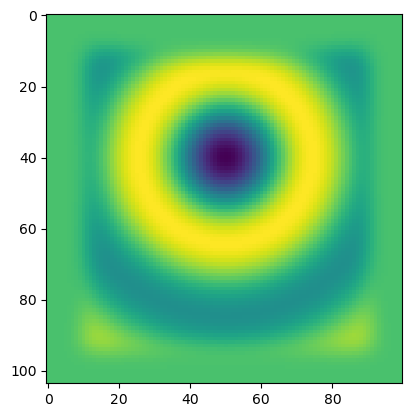

In [3]:
# Let's now initiate the photonics TM FDFD class. Leave the objective empty for now, let's use the class to compute the source field first. 
# s0 and A0 do not have to be passed now, and in general don't need to be passed to do some EM calculations. 
ldos_problem = photonics.Photonics_TM_FDFD(omega = omega, chi = chi, grid_size = (Nx, Ny), pml_size = (Npmlx, Npmly), dl = dl,
    des_mask = design_mask, ji=ji, chi_background=chi_background, sparseQCQP=True, A0=None, s0=None, c0=0.0)

# You can print the ldos problem to see the attributes.
print(ldos_problem)

ei = ldos_problem.get_ei(ji, update=True) # update = true sets the ei to the source field. Not required if you just need to do a Maxwell solve. 
plt.imshow(np.real(ei))

vac_ldos = -np.sum(1/2 * np.real(ji.conj() * ei) * dl * dl)
print("Vacuum LDOS: ", vac_ldos)

In [4]:
# Now let's set s0. We need to restrict ei to the design region. 
ei_design = ei[ldos_problem.des_mask] # restrict the field to the design region
s0 = - (1/4) * 1j * omega * ei_design.conj() * dl * dl
A0 = sp.csc_array(np.zeros((ndof, ndof), dtype=complex))

# We set the objective with set_objective(). 
ldos_problem.set_objective(s0=s0, A0=A0, c0=0.0) 


In [5]:
# We are ready to set up the QCQP for calculating limits. We will use Pdiags = 'global': this represents two constraints (extinction and real power global conservation). We will show how to refine these constraints below, or you may pass Pdiags = 'local' to directly do the local problem (often slower).
ldos_problem.setup_QCQP(Pdiags = 'global', verbose=1) # verbose has a few levels. 0 is silent, 1 is basic output, 2 is more verbose, 3 is very verbose.

# get copies of the QCQP for testing gcd
import copy
gcd_QCQP = copy.deepcopy(ldos_problem.QCQP)
bfgs_splitting_QCQP = copy.deepcopy(ldos_problem.QCQP)

Precomputed 2 A matrices for the projectors.


/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/photonics/photonics.py:196: UserWarning: If both ji and ei are specified then ji is ignored.
  warnings.warn("If both ji and ei are specified then ji is ignored.")
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:468: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:468: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)


In [6]:
## iterative splitting with Newton
ldos_problem.QCQP.solve_current_dual_problem(method='newton')
results = []
result_counter = 0
t = time.time()
for result in ldos_problem.QCQP.iterative_splitting_step(method='newton'): # When we reach pixel level constraints, the generator will return and stop this loop.
    result_counter += 1
    num_constr = ldos_problem.QCQP.get_number_constraints()
    print(f'at step {result_counter}, number of constraints is {num_constr}, bound is {result[0]}')

    results.append((num_constr, result[0]))
print(f'Newton iterative splitting took {time.time()-t}s to reach pixel level.')

Found feasible point for dual problem: [4.76257666e-07 1.00000000e-01] with dualvalue 1181.18011085051


/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:513: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  tmp = self.Acho.cholesky(A)
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:479: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  self.Acho.cholesky_inplace(A)


Splitting projectors: 2 → 4
Precomputed 6 A matrices for the projectors.
previous dual: 1.2027709797001045, new dual: 1.202770979700495 (should be the same)
at step 1, number of constraints is 6, bound is 1.167310004937793
Splitting projectors: 6 → 10
Precomputed 10 A matrices for the projectors.
previous dual: 1.167310004937793, new dual: 1.1673100049514775 (should be the same)
at step 2, number of constraints is 10, bound is 1.0837495754786457
Splitting projectors: 10 → 18
Precomputed 18 A matrices for the projectors.
previous dual: 1.0837495754786457, new dual: 1.0837495755021969 (should be the same)
at step 3, number of constraints is 18, bound is 1.0701394722558182
Splitting projectors: 18 → 34
Precomputed 34 A matrices for the projectors.
previous dual: 1.0701394722558182, new dual: 1.0674196738206034 (should be the same)
at step 4, number of constraints is 34, bound is 1.0437642852552382
Splitting projectors: 34 → 66
Precomputed 66 A matrices for the projectors.
previous dual: 1

In [7]:
## iterative splitting with BFGS
bfgs_splitting_QCQP.solve_current_dual_problem(method='bfgs')
results = []
result_counter = 0
t = time.time()
for result in bfgs_splitting_QCQP.iterative_splitting_step(method='bfgs'): # When we reach pixel level constraints, the generator will return and stop this loop.
    result_counter += 1
    num_constr = ldos_problem.QCQP.get_number_constraints()
    print(f'at step {result_counter}, number of constraints is {num_constr}, bound is {result[0]}')

    results.append((num_constr, result[0]))
print(f'BFGS iterative splitting took {time.time()-t}s to reach pixel level.')

Found feasible point for dual problem: [8.22754787e-07 1.00000000e-01] with dualvalue 1107.0964069383776
Splitting projectors: 2 → 4
Precomputed 6 A matrices for the projectors.
previous dual: 1.2027709797005315, new dual: 1.202770979700977 (should be the same)
at step 1, number of constraints is 800, bound is 1.1673100049563971
Splitting projectors: 6 → 10
Precomputed 10 A matrices for the projectors.
previous dual: 1.1673100049563971, new dual: 1.1673100049574985 (should be the same)
at step 2, number of constraints is 800, bound is 1.083750555971506
Splitting projectors: 10 → 18
Precomputed 18 A matrices for the projectors.
previous dual: 1.083750555971506, new dual: 1.0837505559715235 (should be the same)
at step 3, number of constraints is 800, bound is 1.0656491205659546
Splitting projectors: 18 → 34
Precomputed 34 A matrices for the projectors.
previous dual: 1.0656491205659546, new dual: 1.0650309427572386 (should be the same)
at step 4, number of constraints is 800, bound is 1

In [8]:
t = time.time()
gcd_tol = 1e-2
gcd_QCQP.run_gcd(gcd_tol=1e-2)
print(f'gcd with gcd_tol={gcd_tol} took time {time.time()-t} to reach {gcd_QCQP.current_dual/ldos_problem.QCQP.current_dual} of pixel dual.')

Found feasible point for dual problem: [8.38728301e-07 1.00000000e-01] with dualvalue 1103.966469365856
Precomputed 2 A matrices for the projectors.
At GCD iteration #1, best dual bound found is 1.2027709796990946.
At GCD iteration #2, best dual bound found is 0.9591086370252699.
At GCD iteration #3, best dual bound found is 0.9025716507897908.
At GCD iteration #4, best dual bound found is 0.8812874575302551.
At GCD iteration #5, best dual bound found is 0.8744842590282642.
At GCD iteration #6, best dual bound found is 0.8491539255810056.
At GCD iteration #7, best dual bound found is 0.8387736948118726.
At GCD iteration #8, best dual bound found is 0.8210755570025505.
At GCD iteration #9, best dual bound found is 0.805675465880086.
At GCD iteration #10, best dual bound found is 0.7918075900777496.
At GCD iteration #11, best dual bound found is 0.7856968555501034.
At GCD iteration #12, best dual bound found is 0.7826914691430028.
At GCD iteration #13, best dual bound found is 0.77655727